In [1]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import random
import cv2
import os
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

#function
#載入資料並將label轉換數字
def load_data(imagePaths):
    data = []
    labels = []
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
        image = img_to_array(image)
        data.append(image)

        label = imagePath.split(os.path.sep)[-2]
        labels.append(label)
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    
    return data, labels, lb
#資料路徑排序打亂
def randomPath(random_seed, path_x, path_y):
    random.seed(random_seed)
    random.shuffle(path_x)
    return path_x, path_y
#建立CNN
def build_model(height, width, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1

    model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(256, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(512, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(512, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes, activation="softmax"))

    return model

Using TensorFlow backend.


In [2]:
#set early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0,
                               mode='min', baseline=None, restore_best_weights=True)

EPOCHS = 200 #epochs
INIT_LR = 0.0001 #learning rate
BS = 32 #batch_size
IMAGE_DIMS = (160, 160, 3)
CLASSES = 20

#loading data
print("[INFO] Loading images...")
trainImagePaths = sorted(list(paths.list_images("./VGGFace2/train")))
testImagePaths = sorted(list(paths.list_images("./VGGFace2/test")))


trainImagePaths, testImagePath = randomPath(42,trainImagePaths,testImagePaths)

train_data, train_labels, train_lb = load_data(trainImagePaths)
test_data, test_labels, test_lb = load_data(testImagePaths)


(trainX, trainY, testX, testY) = (train_data, train_labels, test_data, test_labels)

#Data Augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

#building model and training
print("[INFO] Compiling model...")
model = build_model(width=IMAGE_DIMS[0], height=IMAGE_DIMS[1],depth=IMAGE_DIMS[2], classes=len(train_lb.classes_))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
model.summary()

print("[INFO] Training data...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
                        validation_data=(testX, testY),
                        steps_per_epoch=len(trainX) / BS,
                        epochs=EPOCHS, verbose=1,callbacks=[early_stopping])

# save the model
print("[INFO] Save model...")
model.save("VGG_new3.h5")


[INFO] Loading images...
[INFO] Training data matrix: 2679.60MB
[INFO] Test data matrix: 676.20MB
[INFO] Compiling model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 160, 160, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 160, 160, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 160, 160, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 64)        18496  

Epoch 16/200
140/139 [==============================] - 17s 124ms/step - loss: 1.5105 - acc: 0.5505 - val_loss: 1.9775 - val_acc: 0.4472
Epoch 17/200
140/139 [==============================] - 17s 125ms/step - loss: 1.4693 - acc: 0.5566 - val_loss: 2.1936 - val_acc: 0.4392
Epoch 18/200
140/139 [==============================] - 17s 123ms/step - loss: 1.3667 - acc: 0.5811 - val_loss: 2.1031 - val_acc: 0.4508
Epoch 19/200
140/139 [==============================] - 17s 122ms/step - loss: 1.3533 - acc: 0.5922 - val_loss: 1.9349 - val_acc: 0.4889
Epoch 20/200
140/139 [==============================] - 17s 124ms/step - loss: 1.2915 - acc: 0.6050 - val_loss: 1.7957 - val_acc: 0.5067
Epoch 21/200
140/139 [==============================] - 17s 123ms/step - loss: 1.1962 - acc: 0.6364 - val_loss: 1.6824 - val_acc: 0.5306
Epoch 22/200
140/139 [==============================] - 17s 123ms/step - loss: 1.1723 - acc: 0.6367 - val_loss: 1.7383 - val_acc: 0.5439
Epoch 23/200
140/139 [===================

Epoch 76/200
140/139 [==============================] - 17s 123ms/step - loss: 0.1933 - acc: 0.9386 - val_loss: 0.8296 - val_acc: 0.8048
Epoch 77/200
140/139 [==============================] - 17s 125ms/step - loss: 0.2003 - acc: 0.9365 - val_loss: 0.7824 - val_acc: 0.8092
Epoch 78/200
140/139 [==============================] - 18s 125ms/step - loss: 0.2203 - acc: 0.9300 - val_loss: 0.8320 - val_acc: 0.8066
Epoch 79/200
140/139 [==============================] - 17s 123ms/step - loss: 0.2204 - acc: 0.9276 - val_loss: 0.8196 - val_acc: 0.7941
Epoch 80/200
140/139 [==============================] - 17s 124ms/step - loss: 0.1964 - acc: 0.9324 - val_loss: 0.8162 - val_acc: 0.8039
Epoch 81/200
140/139 [==============================] - 18s 125ms/step - loss: 0.1921 - acc: 0.9340 - val_loss: 0.8416 - val_acc: 0.7870
Epoch 82/200
140/139 [==============================] - 17s 123ms/step - loss: 0.1666 - acc: 0.9469 - val_loss: 0.7556 - val_acc: 0.8190
Epoch 83/200
140/139 [===================

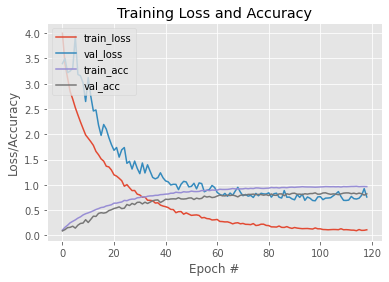

In [4]:
plt.style.use("ggplot")
plt.figure()
N = 119
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig("vgg_new3.png")

In [5]:
#Model evaluate
score = model.evaluate(testX, testY, batch_size=32)
print("loss: "+str(score[0])+", acc: "+str(score[1]))

1127/1127 [==============================] - 1s 888us/step
loss: 0.6834349823254553, acc: 0.8402839396628217
